# Chapter 5 Exercises

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf

import rpy2.robjects as robjects

from scipy.stats import t

import matplotlib.pyplot as plt

## Applied Exercises

### Exercise 5
In Chapter 4, we used logistic regression to predict the probability of `default` using `income` and `balance` on the `Default` data set.  We will now estimate the test error of this logistic regression model using the validation set approach.  Do not forget to set a random seed before beginning your analysis.

In [2]:
default_df = pd.read_csv('../../../datasets/Default.csv')

default_df['default'] = default_df['default'].map({'No':0, 'Yes':1})

In [3]:
default_df.head()

,default,student,balance,income
0,0,No,729.526495,44361.625074
1,0,Yes,817.180407,12106.134700
2,0,No,1073.549164,31767.138947
3,0,No,529.250605,35704.493935
4,0,No,785.655883,38463.495879


#### 5a) Fit a logistic regression model that uses `income` and `balance` to predict `default`.

In [4]:
X = default_df[['balance', 'income']]
y = default_df['default']

lr_model = LogisticRegression()
lr_fit = lr_model.fit(X, y)

In [5]:
lr_preds = lr_fit.predict(X)
accuracy = sum(lr_preds == y) / len(y)

print(f"The model has {accuracy*100:.2f}% classification accuracy.")

The model has 97.37% classification accuracy.


#### 5b) Using the validation set approach, estimate the test error of this model.  In order to do this, you must perform the following steps:
  * i. Split the sample set into a training set and a validation set.
  * ii. Fit a multiple logistic regression model using only the training observations.
  * iii. Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the `default` category if the posterior probability is greater than 0.5.
  * iv. Compute the validation set error, which is the fraction of the observations in the validation set that are misclassified.m

In [6]:
# i. Splitting sample into training and testing sets
num_observations = default_df.shape[0]
n = 8000

np.random.seed(0)
train_idx = np.random.choice(np.arange(0, num_observations), n)

default_train_mask = default_df.index.isin(train_idx)
default_test_mask = ~default_train_mask

X = default_df[['balance', 'income']]
y = default_df['default']

X_train = X[default_train_mask]
y_train = y[default_train_mask]

X_test = X[default_test_mask]
y_test = y[default_test_mask]

In [7]:
# ii. Fitting a multiple regression model on the training observations.
lr_model = LogisticRegression(penalty='none')
lr_fit = lr_model.fit(X_train, y_train)

In [8]:
# iii. Obtaining the prediction of default stats for each individual in the validation (testing) set.
lr_preds = lr_fit.predict(X_test)

In [9]:
# iv. Computing the validation set error
validation_accuracy = sum(lr_preds == y_test) / len(y_test)
print(f"This model has {accuracy*100:}% classification accuracy on validation data.")

This model has 97.37% classification accuracy on validation data.


#### 5c) Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set.  Comment on the results obtained.

In [10]:
def generate_test_accuracy(df, N = 5000, get_dummy=False):
    num_observations = df.shape[0]
    n = N

    train_idx = np.random.choice(np.arange(0, num_observations), n)

    train_mask = df.index.isin(train_idx)
    test_mask = ~train_mask
    
    X = df[['balance', 'income']]
    y = df['default']
    
    # This is for Question 5d)
    if get_dummy == True:
        student_dummy = pd.get_dummies(default_df['student'], drop_first=True)
        X = pd.concat([X, student_dummy], axis=1)

    X_train = X[train_mask]
    y_train = y[train_mask]

    X_test = X[test_mask]
    y_test = y[test_mask]

    lr_model = LogisticRegression(penalty='none')
    lr_fit = lr_model.fit(X_train, y_train)
    
    lr_preds = lr_fit.predict(X_test)
    accuracy = sum(lr_preds == y_test) / len(y_test)

    return accuracy

In [11]:
test_accuracies = []
num_iter = 3

for i in range(num_iter):
    # Using random seed for reproducibility
    np.random.seed(i)
    
    test_accuracy = generate_test_accuracy(default_df, N = 8000)
    test_accuracies.append(test_accuracy)
    
mean_test_accuracy = np.mean(test_accuracies)

Mean test accuracy for 3 iterations: 97.00%


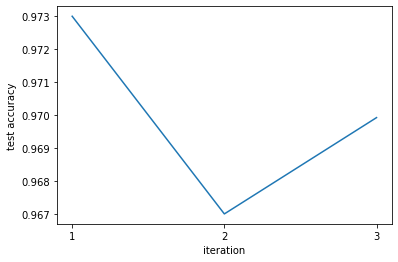

In [12]:
plt.plot([1,2,3], test_accuracies)
plt.xticks([1,2,3])
plt.xlabel('iteration')
plt.ylabel('test accuracy')
print(f"Mean test accuracy for {num_iter} iterations: {mean_test_accuracy*100:.2f}%");

Using a validation set approach, we see some variation in the testing accuracy.  This is due to fitting the slightly different models that result from being fit on different train/test splits.

#### 5d) Now consider a logistic regression model that predicts the probability of `default` using `income`, `balance`, and a dummy variable for `student`.  Estimate the test error for this model using the validation set approach.  Comment on whether or not including a dummy variable for `student` leads to a reduction in the test error rate.

In [13]:
np.random.seed(0)
train_idx = np.random.choice(np.arange(0, num_observations), n)

default_train_mask = default_df.index.isin(train_idx)
default_test_mask = ~default_train_mask

student_dummy = pd.get_dummies(default_df['student'], drop_first=True)

X = default_df[['balance', 'income']]
X_dummy = pd.concat([X, student_dummy], axis=1)
y = default_df['default']

X_train = X_dummy[default_train_mask]
y_train = y[default_train_mask]

X_test = X_dummy[default_test_mask]
y_test = y[default_test_mask]

lr_model_dummy = LogisticRegression(penalty='none')
lr_fit_dummy = lr_model_dummy.fit(X_train, y_train)

lr_preds = lr_fit_dummy.predict(X_test)
accuracy = sum(lr_preds == y_test) / len(y_test)

print(f"This model has {accuracy*100:.2f}% classification accuracy on validation data, when the binary variable 'student' is included as a predictor.")

This model has 96.74% classification accuracy on validation data, when the binary variable 'student' is included as a predictor.


In [14]:
test_accuracies = []

for i in range(num_iter):
    # Using random seed for reproducibility
    np.random.seed(i)
    
    test_accuracy = generate_test_accuracy(default_df, N = 8000, get_dummy=True)
    test_accuracies.append(test_accuracy)
    
bstrap_mean_accuracy = np.mean(test_accuracies)

print(f"Estimating the testing error using a bootstrap process {num_iter} times, the average testing error is {bstrap_mean_accuracy*100:.2f}.")

Estimating the testing error using a bootstrap process 3 times, the average testing error is 96.81.


There error from the validation approach when `student` is included is less than when `student` is not included, however it's a very minor difference. The `student` dummy variable doesn't seem to add much predictive power to the model.

### Exercise 6
We continue to consider the use of a logstic regression model to predict the probability of `default` using `income` and `balance` on the `Default` data set.  In particular, we will now compute estimates for the standard errors of the `income` and `balance` logistic regression coefficients in two different ways: (1) using the bootstrap, and (2) using the standard formula for computing the standard errors in the `glm()` function.  Do not forget to set a random seed before beginning your analysis.

#### 6a) Using the `summary()` and `glm()` functions, determine the estimated standard errors for the coefficients associated with `income` and `balance` in a multiple logistic regression model that uses both predictors.

In [15]:
## Although I used sklearn and LogisticRegression earlier, it's easier to get the standard errors using statsmodels.  If we use the smf.glm() function with the family set to Binomial, it performs logistic regression.
glm_fit = smf.glm(formula='default ~ income + balance', 
                  data = default_df, 
                  family = sm.families.Binomial()
              ).fit()

In [16]:
glm_fit.bse

Intercept    0.434772
income       0.000005
balance      0.000227
dtype: float64

##### Cofficients of sklearn vs statsmodels

In [17]:
glm_fit.params

Intercept   -11.540468
income        0.000021
balance       0.005647
dtype: float64

In [18]:
print(f"The intercept from sklearn's LinearRegression is: {lr_fit.intercept_[0]:6f}")

The intercept from sklearn's LinearRegression is: -11.433001


In [19]:
print(f"The income coefficient from sklearn's LinearRegression is: {lr_fit.coef_[0][1]:6f}")
print(f"The balance coefficient from sklearn's LinearRegression is: {lr_fit.coef_[0][0]:6f}")

The income coefficient from sklearn's LinearRegression is: 0.000020
The balance coefficient from sklearn's LinearRegression is: 0.005566


The intercept and coefficients are slightly different when using sklearn and LogisticRegression vs. using statsmodels and smf.glm(), however I haven't been able to pinpoint why exactly.  The coefficients and intercepts are so close that it's not that important and getting the standard errors from `smf.glm()` seems ok, despite using LogisticRegression from sklearn earlier.

#### 6b) Write a function, `boot.fn()`, that takes as input the `Default` data set as well as an index of the observations, and that outputs the coefficient estimates for `income` and `balance` in the multiple logistic regression model.

In [20]:
def boot_fn(data, index):
    model = smf.glm(formula = 'default ~ income + balance', 
                    data = data, 
                    subset = index,
                    family = sm.families.Binomial()
                   )
    fit = model.fit()
    coefficients = fit.params
    
    return coefficients

#### 6c) Use the `boot()` function together with your `boot.fn()` function to estimate the standard errors of the logistic regression coefficients for `income` and `balance`.

In [21]:
intercepts = []
income_coefficients = []
balance_coefficients = []
num_iter = 1000

for i in range(num_iter):
    # Using random seed for reproducability
    np.random.seed(i)
    
    bstrap_idx = np.random.choice(np.arange(0, num_observations), num_observations)
    results = boot_fn(default_df, bstrap_idx)
    
    intercept = results[0]
    income_coefficient = results[1]
    balance_coefficient = results[2]
    
    intercepts.append(intercept)
    income_coefficients.append(income_coefficient)
    balance_coefficients.append(balance_coefficient)

In [22]:
intercept_std_err = np.std(intercepts, ddof=1)
income_std_err = np.std(income_coefficients, ddof=1)
balance_std_err = np.std(balance_coefficients, ddof=1)

print(f"The standard error of the intercept from bootstrapping with {num_iter} iterations is {intercept_std_err:.6f}.")
print()
print(f"The standard error of the coefficient for income from bootstrapping with {num_iter} iterations is {income_std_err:.6f}.")
print()
print(f"The standard error of the coefficient for balance from bootstrapping with {num_iter} iterations is {balance_std_err:.6f}.")

The standard error of the intercept from bootstrapping with 1000 iterations is 0.445314.

The standard error of the coefficient for income from bootstrapping with 1000 iterations is 0.000005.

The standard error of the coefficient for balance from bootstrapping with 1000 iterations is 0.000232.


#### 6d) Comment on the estimated standard errors obtained using the `glm()` function and using your bootstrap function.

The standard errors from `glm()` are very close to the bootstrap estimates, however there is some variation in the bootstrap estimates.  This is because each of them was obtained by fitting and validating a Logistic Regression model on different training/testing splits of the data.

### Exercise 7
In Section 5.3.2 and 5.3.3, we saw that the `cv.glm()` function can be used in order to compute the LOOCV test error estimate.  Alternatively, one could compute those quantities using just the `glm()` and `predict.glm()` functions, and a for loop.  You will now take this approach in order to compute the LOOCV error for a simple logistic regression model on the `Weekly` data set.  Recall that in the context of classification problems, the LOOCV error is given in (5.4).

In [23]:
weekly_df = pd.read_csv("../../../datasets/Weekly.csv")

weekly_df['Direction_int'] = weekly_df['Direction'].map({'Down':0, 'Up':1})

In [24]:
weekly_df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction_int
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down,0
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down,0
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up,1
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up,1
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up,1


#### 7a) Fit a logistic regression model that predicts `Direction` Using `Lag1` and `Lag2`

In [25]:
glm_fit = smf.glm(formula='Direction_int ~ Lag1 + Lag2', 
                  data = weekly_df, 
                  family = sm.families.Binomial()
              ).fit()
glm_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          Direction_int   No. Observations:                 1089
Model:                            GLM   Df Residuals:                     1086
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -744.11
Date:                Sun, 22 Jan 2023   Deviance:                       1488.2
Time:                        23:33:05   Pearson chi2:                 1.09e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.007303
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2212      0.061      3.599      0.000       0.101       0.342
Lag1          -0.0387      0.026     -1.477      0.140      -0.090       0.013
Lag2           0.0602      0.027      2.270      0.023       0.008       0.112
==============================================================================
"""

#### 7b) Fit a logistic regression model that predicts `Direction` and using `Lag1` and `Lag2` *using all but the first observation.*

##### Using `smf.glm()`

In [26]:
glm_fit = smf.glm(formula='Direction_int ~ Lag1 + Lag2', 
                  data = weekly_df[1:], 
                  family = sm.families.Binomial()
              ).fit()
glm_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          Direction_int   No. Observations:                 1088
Model:                            GLM   Df Residuals:                     1085
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -743.26
Date:                Sun, 22 Jan 2023   Deviance:                       1486.5
Time:                        23:33:05   Pearson chi2:                 1.09e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.007373
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2232      0.061      3.630      0.000       0.103       0.344
Lag1          -0.0384      0.026     -1.466      0.143      -0.090       0.013
Lag2           0.0608      0.027      2.291      0.022       0.009       0.113
==============================================================================
"""

##### Using sklearn `LogisticRegression()`

In [27]:
X = weekly_df.loc[1:, ['Lag1', 'Lag2']]
y = weekly_df.loc[1:, 'Direction_int']

lr_model = LogisticRegression(penalty='none')
lr_fit = lr_model.fit(X, y)

In [28]:
lr_fit.intercept_

array([0.22324305])

In [29]:
lr_fit.coef_

array([[-0.03843317,  0.06084763]])

In this case, both the statsmodels and sklearn model have the same coefficients as compared to earlier where they were slightly off.

#### 7c) Use the model from (b) to predict the direction of the first observation.  You can do this by predicting that the first observation will go up if $P(Direction = "Up"|Lag1, Lag2) > 0.5$.  Was this observation correctly classified?

##### Using smf.glm()

In [30]:
glm_pred = glm_fit.predict(weekly_df.loc[[0], ['Lag1', 'Lag2']])
print(f"Predicted probability of 0 (down): {(1 - glm_pred[0]):.4f}")
print(f"Predicted probability of 1 (up): {glm_pred[0]:.4f}")

Predicted probability of 0 (down): 0.4286
Predicted probability of 1 (up): 0.5714


##### Using sklearn LogisticRegression()

In [31]:
lr_preds = lr_fit.predict(weekly_df.loc[[0], ['Lag1', 'Lag2']])
lr_proba = lr_fit.predict_proba(weekly_df.loc[[0], ['Lag1', 'Lag2']])
lr_preds, lr_proba

print(f'Prediction: {lr_preds[0]}')
print(f"Predicted probability of 0 (down): {lr_proba[0][0]:.4f}")
print(f"Predicted probability of 1 (up): {lr_proba[0][1]:.4f}")

Prediction: 1
Predicted probability of 0 (down): 0.4286
Predicted probability of 1 (up): 0.5714


As expected, because the coefficients of the models created from sklearn and smf are the same, we see the predictions and probabilities of those predictions are also the same.

#### 7d) Write a for loop from $i=1$ to $i=n$, where $n$ is the number of observations in the data set, that performs each of the following steps:
  * i. Fit a logistic regression model using all but the $i$th observation to predict `Direction` using `Lag1` and `Lag2`.
  * ii. Compute the posterior probability of the market moving up for the $i$th observation.
  * iii. Use the posterior probability for the $i$th observation in order to predict whether or not the market moves up.
  * iv. Determine whether or not an error was made in predicting the direction for the $i$th obsevation.  If an error was made, then indicate this as a 1, and otherwise indicate is at a 0.

In [32]:
n = weekly_df.shape[0]
errors = []

for i in range(n):
    test_mask = weekly_df.index.isin([i])
    train_mask = ~test_mask
    
    X_train = weekly_df[train_mask][['Lag1', 'Lag2']]
    y_train = weekly_df[train_mask]['Direction_int']
    
    X_test = weekly_df[test_mask][['Lag1', 'Lag2']]
    y_test = weekly_df[test_mask]['Direction_int']

    lr_model = LogisticRegression(penalty='none')
    lr_fit = lr_model.fit(X_train, y_train)
    
    lr_pred = lr_fit.predict(X_test)
    
    #print(i)
    
    if lr_pred[0] != y_test.values[0]:
        errors.append(1)
    else:
        errors.append(0)

#### 7e) Take the average of the $n$ numbers obtained in (d)iv in order to obtain the Leave One Out Cross Validation (LOOCV) estimate for the test error.  Comment on the results.

In [33]:
error_rate = np.mean(errors)        
print(f"LOOCV test error rate: {error_rate*100:.2f}%.")

LOOCV test error rate: 45.00%.


Using LOOCV, we estimate the error rate of our model to be about 45%.  In other words, if we were to use the model to make a prediction based on new data, the model would typically make an incorrect classification roughly 45% of the time.  

Because LOOCV generates and creates many different models based on many different train/test splits of the dataset, the LOOCV estimate of the error rate should have less variability and provie a better estimate of the true error rate of the model.  This is in contrast to the validation set approach where only a single model is trained on one train/test split of the dataset, which will lead to more variability and poorer estimates.

### Exercise 8
We will now perform cross-validation on a simulated data set.

#### 8a) Generate a simulated data set as follows:

In [34]:
data = robjects.r("""
set.seed(1)
x <- rnorm(100)
""")

x = np.array(data)
x = np.sort(x)

data = robjects.r("""
set.seed(1)
x <- rnorm(100)
y <- x - 2 * x^2 + rnorm(100)
""")

y = np.array(data)
y = np.sort(y)

In this data set, what is $n$ and what is $p$?  Write out the model used to generate the data in equation form.

There are 100 observations ($n=100$) and 1 predictor ($p=1$)

The equation is: $y = x - 2x^2 + \epsilon \text{, where } \epsilon \sim N(0,1)$

#### Exercise 8b) Create a scatter plot of $X$ against $Y$.  Comment on what you find.

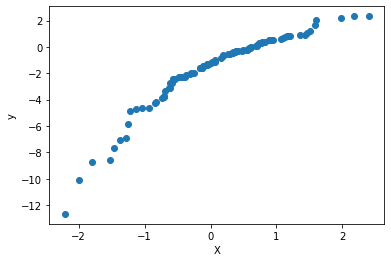

In [35]:
plt.scatter(x, y)
plt.xlabel('X')
plt.ylabel('y');

The scatter plot shows some curvature indicating the relationship between X and Y is likely to be non-linear.  In truth, we know the true relationship to be quadratic, however without that knowledge, a cubic or even quartic relationship both appear reasonable.  

In practice, one won't know the true relationship and further investigation is necessary.  Onward we go.

#### 8c) Set a random seed, and then compute LOOCV errors that result from fitting the following four models using least squares:

  * i. $Y = \beta_0 + \beta_1 X + \epsilon$
  * ii. $Y = \beta_0 + \beta_1 X +\beta_2 x^2 + \epsilon$
  * iii. $Y = \beta_0 + \beta_1 X + \beta_2 x^2 + \beta_3 x^3 + \epsilon$
  * iv. $Y = \beta_0 + \beta_1 X + \beta_2 x^2 + \beta_3 x^3 + \beta_4 x^4 + \epsilon$
  
Note you may find it helpful to use the `data.frame()` function to create a single data set containing both $X$ and $Y$.

In [36]:
df = pd.DataFrame(np.concatenate((x.reshape(-1,1), y.reshape(-1,1)), axis=1), columns = ['x', 'y'])
#df.head()

In [37]:
# linear_fit = smf.ols(formula='y ~ x', data = df).fit()
# linear_fit.summary()

##### 8ci) $Y = \beta_0 + \beta_1 X + \epsilon$

In [38]:
n = df.shape[0]
errors = np.array([])

for i in range(n):
    test_mask = df.index.isin([i])
    train_mask = ~test_mask
    
    df_train = df[train_mask]
    df_test = df[test_mask]

    linear_model = smf.ols(formula='y ~ x', data = df_train)
    linear_fit = linear_model.fit()
    
    linear_pred = linear_fit.predict(df_test['x'])
    
    #print(i)
    error = df_test['y'] - linear_pred
    
    errors = np.append(errors, error)
    
linear_error = np.mean(errors**2)

In [39]:
linear_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     731.6
Date:                Sun, 22 Jan 2023   Prob (F-statistic):           5.65e-47
Time:                        23:33:13   Log-Likelihood:                -130.09
No. Observations:                  99   AIC:                             264.2
Df Residuals:                      97   BIC:                             269.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8335      0.092    -19.958      0.000      -2.016      -1.651
x              2.8494      0.105     27.048      0.000       2.640       3.059
==============================================================================
Omnibus:                       58.092   Durbin-Watson:                   0.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.210
Skew:                          -2.056   Prob(JB):                     1.67e-45
Kurtosis:                       8.752   Cond. No.                         1.18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### 8cii) $Y = \beta_0 + \beta_1 X +\beta_2 x^2 + \epsilon$

In [40]:
n = df.shape[0]
errors = np.array([])

for i in range(n):
    test_mask = df.index.isin([i])
    train_mask = ~test_mask
    
    df_train = df[train_mask]
    df_test = df[test_mask]

    quad_model = smf.ols(formula='y ~ x + I(x**2)', data = df_train)
    quad_fit = quad_model.fit()
    
    quad_pred = quad_fit.predict(df_test['x'])
    
    #print(i)
    error = df_test['y'] - quad_pred
    
    errors = np.append(errors, error)
    
quad_error = np.mean(errors**2)

In [41]:
quad_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2463.
Date:                Sun, 22 Jan 2023   Prob (F-statistic):           3.21e-83
Time:                        23:33:14   Log-Likelihood:                -40.383
No. Observations:                  99   AIC:                             86.77
Df Residuals:                      96   BIC:                             94.55
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2254      0.046    -26.463      0.000      -1.317      -1.133
x              2.8576      0.043     66.778      0.000       2.773       2.943
I(x ** 2)     -0.8006      0.036    -22.179      0.000      -0.872      -0.729
==============================================================================
Omnibus:                       10.832   Durbin-Watson:                   0.545
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               23.173
Skew:                           0.294   Prob(JB):                     9.29e-06
Kurtosis:                       5.296   Cond. No.                         2.09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### 8ciii) $Y = \beta_0 + \beta_1 X + \beta_2 x^2 + \beta_3 x^3 + \epsilon$

In [42]:
n = df.shape[0]
errors = np.array([])

for i in range(n):
    test_mask = df.index.isin([i])
    train_mask = ~test_mask
    
    df_train = df[train_mask]
    df_test = df[test_mask]

    cubic_model = smf.ols(formula='y ~ x + I(x**2) + I(x**3)', data = df_train)
    cubic_fit = cubic_model.fit()
    
    cubic_pred = cubic_fit.predict(df_test['x'])
    
    #print(i)
    error = df_test['y'] - cubic_pred
    
    errors = np.append(errors, error)
    
cubic_error = np.mean(errors**2)

In [43]:
cubic_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     3110.
Date:                Sun, 22 Jan 2023   Prob (F-statistic):           1.14e-94
Time:                        23:33:15   Log-Likelihood:                -8.7053
No. Observations:                  99   AIC:                             25.41
Df Residuals:                      95   BIC:                             35.79
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2106      0.034    -35.774      0.000      -1.278      -1.143
x              2.4350      0.055     43.926      0.000       2.325       2.545
I(x ** 2)     -0.7911      0.026    -30.000      0.000      -0.843      -0.739
I(x ** 3)      0.1951      0.021      9.228      0.000       0.153       0.237
==============================================================================
Omnibus:                       22.426   Durbin-Watson:                   1.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.195
Skew:                          -0.490   Prob(JB):                     6.44e-23
Kurtosis:                       7.880   Cond. No.                         5.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### 8civ) $Y = \beta_0 + \beta_1 X + \beta_2 x^2 + \beta_3 x^3 + \beta_4 x^4 + \epsilon$

In [44]:
n = df.shape[0]
errors = np.array([])

for i in range(n):
    test_mask = df.index.isin([i])
    train_mask = ~test_mask
    
    df_train = df[train_mask]
    df_test = df[test_mask]

    quartic_model = smf.ols(formula='y ~ x + I(x**2) + I(x**3) + I(x**4)', data = df_train)
    quartic_fit = quartic_model.fit()
    
    quartic_pred = quartic_fit.predict(df_test['x'])
    
    #print(i)
    error = df_test['y'] - quartic_pred
    
    errors = np.append(errors, error)
    
quartic_error = np.mean(errors**2)

In [45]:
quartic_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2405.
Date:                Sun, 22 Jan 2023   Prob (F-statistic):           1.01e-93
Time:                        23:33:17   Log-Likelihood:                -6.6854
No. Observations:                  99   AIC:                             23.37
Df Residuals:                      94   BIC:                             36.35
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1688      0.039    -29.626      0.000      -1.247      -1.091
x              2.4392      0.055     44.638      0.000       2.331       2.548
I(x ** 2)     -0.9229      0.071    -12.908      0.000      -1.065      -0.781
I(x ** 3)      0.1964      0.021      9.426      0.000       0.155       0.238
I(x ** 4)      0.0354      0.018      1.979      0.051      -0.000       0.071
==============================================================================
Omnibus:                       17.612   Durbin-Watson:                   1.142
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.497
Skew:                           0.048   Prob(JB):                     6.07e-20
Kurtosis:                       7.631   Cond. No.                         13.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
print(f"Linear LOOCV error: {linear_error:.4f}")
print(f"Quadratic LOOCV error: {quad_error:.4f}")
print(f"Cubic LOOCV error: {cubic_error:.4f}")
print(f"Quartic LOOCV error: {quartic_error:.4f}")

Linear LOOCV error: 0.9622
Quadratic LOOCV error: 0.1758
Cubic LOOCV error: 0.0821
Quartic LOOCV error: 0.0926


#### 8d) Repeat (c) using another random seed, and report your results.  Are your results the same as what you got in (c)? Why?

LOOCV works by selecting one observation to hold out of the dataset, which is used as test data.  The model is trained on the remaining $n-1$ observations and then tested on the one observation that was held out.  This process repeats for every observation in the dataset, producing n different train/test splits.

Because LOOCV always split the dataset into the same n splits, there's no randomness in the splitting process and the LOOCV error is deterministic.  As a result, setting a random seed when performing LOOCV isn't necessary and we would expect to get the same LOOCV error even when using a different random seed.  

#### 8e) Which of the models in (c) had the smallest LOOCV error?  Is this what you expected?  Explain your answer.

The cubic model had the lowest LOOCV error, despite the true relationship being quadratic.  This is normal and is because of the random error term included when generating the model.  The degree of the model with the lowest LOOCV error isn't guaranteed to be the same as the degree of the true model, however we would expect them to be close, which is the case here.  The true model has degree 2, while the model with the lowest LOOCV has degree 3.

#### 8f) Comment on the statistical significance of the coefficient estimates that results from fitting each of the models in (c) using least squares.  Do these results agree with the conclusions drawn on the cross-validation results?

##### Linear model

In [47]:
linear_results = linear_fit.summary().tables[1]

results_as_html = linear_results.as_html()
results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]

results_df[['coef', 'std err', 't', 'P>|t|']]

,coef,std err,t,P>|t|
Intercept,-1.8335,0.092,-19.958,0.0
x,2.8494,0.105,27.048,0.0


In the linear model, with degree 1, the linear term ($x$) has a P-value of approximately 0, indicating the linear term is statistically significant in regards to the model's predictive power. 

In [48]:
quad_results = quad_fit.summary().tables[1]

results_as_html = quad_results.as_html()
results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]

results_df[['coef', 'std err', 't', 'P>|t|']]

,coef,std err,t,P>|t|
Intercept,-1.2254,0.046,-26.463,0.0
x,2.8576,0.043,66.778,0.0
I(x ** 2),-0.8006,0.036,-22.179,0.0


In the quadratic model, with degree 2, the linear term ($x$) and quadratic term ($x^2$) have P-values of approximately 0, indicating both terms are statistically significant in regards to the model's predictive power. 

In [49]:
cubic_results = cubic_fit.summary().tables[1]

results_as_html = cubic_results.as_html()
results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]

results_df[['coef', 'std err', 't', 'P>|t|']]

,coef,std err,t,P>|t|
Intercept,-1.2106,0.034,-35.774,0.0
x,2.4350,0.055,43.926,0.0
I(x ** 2),-0.7911,0.026,-30.000,0.0
I(x ** 3),0.1951,0.021,9.228,0.0


In the cubic model, with degree 3, the linear term ($x$), quadratic term ($x^2$), and cubic term ($x^3$) have P-values of approximately 0, indicating all three terms are statistically significant in regards to the model's predictive power. 

In [50]:
quartic_results = quartic_fit.summary().tables[1]

results_as_html = quartic_results.as_html()
results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]

results_df[['coef', 'std err', 't', 'P>|t|']]

,coef,std err,t,P>|t|
Intercept,-1.1688,0.039,-29.626,0.000
x,2.4392,0.055,44.638,0.000
I(x ** 2),-0.9229,0.071,-12.908,0.000
I(x ** 3),0.1964,0.021,9.426,0.000
I(x ** 4),0.0354,0.018,1.979,0.051


In the quartic model, with degree 4, the linear term ($x$), quadratic term ($x^2$), and cubic term ($x^3$) still have P-values of approximately 0.  However, the quartic term($x^4$) has a p-value greater than the typical cutoff of ($\alpha=0.05$), indicating that the quartic term doesn't significantly improve the model's predictive power.

Because the linear, quadratic, and cubic terms are all statistically significant, that's why we see an initial increase in LOOCV error going from a linear model to a cubic model, then a decrease in LOOCV error in the quartic model.  Adding the quadratic term to the linear model increases predictive power, resulting in a lower LOOCV error for the quadratic model.  This happens again when adding the cubic term to the quadratic model, which increases predictive power of the cubic model as compared to the quadratic model.  However, since the quartic term is not statistically significant, addind it to the model doesn't help improve predictive power.  Instead, it decreases predictive power and leads to more error.

### Exercise 9
We will now consider the `Boston` housing data set, from the `ISLR2` library.

In [51]:
boston_df = pd.read_csv('../../../datasets/Boston.csv')

In [52]:
boston_df.head()

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


#### 9a) Based on this data set, provide an estimate for the population mean of `medv`.  Call this estimate $\hat{\mu}$.

In [53]:
mu_hat = boston_df['medv'].mean()
print(f"Estimate of true population mean of medv (Mu_hat): {mu_hat:.3f}")

Estimate of true population mean of medv (Mu_hat): 22.533


#### 9b) Provide an estimate of the standard error of $\hat{\mu}$.  Interpret this result.
*Hint: We can compute the standard error of the sample mean by dividing the sample standard deviation by the square root of the number of observations.*

In [54]:
n = boston_df.shape[0]

samp_std_dev = boston_df['medv'].std()

se_mu_hat = samp_std_dev / np.sqrt(n)

print(f"Estimate of the standard error of the true population mean of medv (Mu hat): {se_mu_hat:.4f}")

Estimate of the standard error of the true population mean of medv (Mu hat): 0.4089


Interpretation: The standard error of an estimate of the population value quantifies how much error our estimate of the true population value will have.  

A larger standard error indicates our estimates have less accuracy and are likely to be very different from the true value we're estimating.  A lower standard error indicates our estimates will often be close to the true value and are more reliable.  In short, less error, means better estimates.  

For the Boston dataset, when using the sample mean ($\bar{x}_{\text{medv}}$) to estimate the true population mean ($\mu_{\text{medv}}$), we typically expect our estimate to be off by about $\pm SE(\hat{\mu})$ or $\pm0.4089$.

#### 9c) Now estimate the standard error of $\hat{\mu}$ using the bootstrap.  How does this compare to your answer from (b)?

$$SE(\hat{\mu})=\sqrt{\frac{1}{n-1}\sum_{r=1}^{n}(\hat{\mu}_{r} - \mu_{\hat{\mu}}})^2$$
$$SE_{B}(\hat{\mu})=\sqrt{\frac{1}{B-1}\sum_{r=1}^{B}(\hat{\mu}^{*r} - \frac{1}{B}\sum_{r\prime=1}^{B}\hat{\mu}^{*r\prime}})^2$$

In [55]:
bstrap_mu_hats = np.array([])
B = 1000

for i in range(B):
    bstrap_sample = boston_df.sample(n = n, replace=True, random_state=i)
    bstrap_mu_hat = bstrap_sample['medv'].mean()
    bstrap_mu_hats = np.append(bstrap_mu_hats, bstrap_mu_hat)
    
mu_of_bstrap_mu_hats = 1 / B * np.sum(bstrap_mu_hats)
squared_deviations_of_bstrap_mu_hats = (bstrap_mu_hats - mu_of_bstrap_mu_hats)**2
variance_of_bstrap_mu_hats = 1 / (B - 1) * np.sum(squared_deviations_of_bstrap_mu_hats)
std_error_of_bstrap_mu_hats = np.sqrt(variance_of_bstrap_mu_hats)

In [56]:
print(f"Bootstrap estimate of standard error of Mu hat: {std_error_of_bstrap_mu_hats:.4f}")

Bootstrap estimate of standard error of Mu hat: 0.4266


The standard error of mu hat from the bootstrap: $SE_{B}(\hat{\mu})=0.4266$ is very close to the standard error of mu hat ($SE(\hat{\mu})$) calculated from the formula: $SE(\hat{\mu}) = \frac{s_{\bar{x}}}{\sqrt{n}}=0.4089$.

#### 9d) Based on the bootstrap estimate from (c), provide a 95% confidence interval for the mean of `medv`.  Compare it to the results obtained using `t.test(Boston$medv)`.
*Hint: You can approximate a 95% confidence interval using the formula $[\hat{\mu} - 2SE(\hat{\mu}), \hat{\mu}+2SE(\hat{\mu})]$.*

In [57]:
bstrap_mu_lower_bound = mu_of_bstrap_mu_hats - 2 * std_error_of_bstrap_mu_hats
bstrap_mu_upper_bound = mu_of_bstrap_mu_hats + 2 * std_error_of_bstrap_mu_hats

print(f"Bootstrap confidence interval for Mu: ({bstrap_mu_lower_bound:.3f}, {bstrap_mu_upper_bound:.3f})")

Bootstrap confidence interval for Mu: (21.675, 23.382)


Using the bootstrap process, our ~95% confidence interval for the true population mean `medv` is: $21.675 < \mu < 23.382$

##### Comparing against `t.test(Boston$medv)`
In R, `t.test(Boston$medv)` would calculate the 95% confidence interval using the formula:
$$\hat{\mu}\pm t_c \frac{s_x}{\sqrt{n}}, \text{ where } \hat{\mu}=\bar{x}$$
$$\hat{\mu} - t_c \frac{s_x}{\sqrt{n}} < \mu < \hat{\mu} + t_c \frac{s_x}{\sqrt{n}}$$

We can replicate this behavior in Python as follows:

In [58]:
conf_level = 0.95
alpha = 1 - conf_level

t_critical = t.ppf(q = 1 - alpha/2, df = n-1)

t_int_lower_bound = mu_hat - t_critical * se_mu_hat
t_int_upper_bound = mu_hat + t_critical * se_mu_hat

print(f"Student t confidence interval for Mu: ({t_int_lower_bound:.3f}, {t_int_upper_bound:.3f})")

Student t confidence interval for Mu: (21.730, 23.336)


Calculating the confidence interval using the Student t-distribution, our ~95% confidence interval for the true population mean `medv` is: $21.730 < \mu < 23.336$.  The bootstrap confidence interval of ${\mu}$ is quite close to the one generated from the more standard approach that uses the t-distribution.  

This will be a nice tool to have for when we want to use confidence intervals, however no formula exists for constructing the confidence interval for our parameter of interest.

#### 9e) Based on this data set, provide an estimate, $\hat{\mu}_{\text{med}}$, for the median value of `medv` in the population.

In [59]:
mu_hat_med = boston_df['medv'].median()
print(f"Estimate of true population Median value of medv: {mu_hat_med}")

Estimate of true population Median value of medv: 21.2


#### 9f) We now would like to estimate the standard error of $\hat{\mu}_{\text{med}}$.  Unfortunately, there is no simple formula for computing the standard error of the median.  Instead, estimate the standard error of the median using the bootstrap.  Comment on your findings.

$$SE_{B}(\hat{\mu}_{\text{medv}})=\sqrt{\frac{1}{B-1}\sum_{r=1}^{B}(\hat{\mu}_{\text{medv}}^{*r} - \frac{1}{B}\sum_{r\prime=1}^{B}\hat{\mu}_{\text{medv}}^{*r\prime}})^2$$

In [60]:
bstrap_median_hats = np.array([])
B = 1000

for i in range(B):
    bstrap_sample = boston_df.sample(n = n, replace=True, random_state=i)
    bstrap_median_hat = bstrap_sample['medv'].median()
    bstrap_median_hats = np.append(bstrap_median_hats, bstrap_median_hat)
    
mu_of_bstrap_median_hats = 1 / B * np.sum(bstrap_median_hats)
squared_deviations_of_bstrap_median_hats = (bstrap_median_hats - mu_of_bstrap_median_hats)**2
variance_of_bstrap_median_hats = 1 / (B - 1) * np.sum(squared_deviations_of_bstrap_median_hats)
std_error_of_bstrap_median_hats = np.sqrt(variance_of_bstrap_median_hats)

In [61]:
print(f"Bootstrap estimate of standard error of the true population Median value of medv: {std_error_of_bstrap_median_hats:.4f}")

Bootstrap estimate of standard error of the true population Median value of medv: 0.3920


The standard error of the population median value tells us how much our estimate of the population median value will typically be off from the true value.  In this case, if we use the sample median value of `medv` from the Boston dataset to estimate the true median value of `medv`, it's typical that our estimate will be off by as much as 0.392.

Because the standard error was generated from a bootstrap process, the 0.392 is just an estimate of the standard error of $\hat{\mu}_{\text{medv}}$ and is subject to some variability, but we expect it to be close to the true standard error, most of the time, and therefore a good estimator.  As there is no formula to calculate the standard error for $\hat{\mu}_{\text{medv}}$, the best we can do is estimate it using the bootstrap process anyways.

#### 9g) Based on this data set, provide an estimate for the tenth percentile of `medv` in Boston census tracts.  Call this quantity $\hat{\mu}_{0.1}$. (You can use the `quantile()` function.)

In [62]:
mu_hat_point_1 = boston_df['medv'].quantile(q=0.1)
print(f"Estimate of true population 10th percentile of medv: {mu_hat_point_1}")

Estimate of true population 10th percentile of medv: 12.75


#### 9h) Use the bootstrap to estimate the standard error of $\hat{\mu}_{0.1}$.  Comment on your findings.

In [63]:
bstrap_point_1_hats = np.array([])
B = 1000
quantile = 0.1

for i in range(B):
    bstrap_sample = boston_df.sample(n = n, replace=True, random_state=i)
    bstrap_point_1_hat = bstrap_sample['medv'].quantile(q=quantile)
    bstrap_point_1_hats = np.append(bstrap_point_1_hats, bstrap_point_1_hat)
    
mu_of_bstrap_point_1_hats = 1 / B * np.sum(bstrap_point_1_hats)
squared_deviations_of_bstrap_point_1_hats = (bstrap_point_1_hats - mu_of_bstrap_point_1_hats)**2
variance_of_bstrap_point_1_hats = 1 / (B - 1) * np.sum(squared_deviations_of_bstrap_point_1_hats)
std_error_of_bstrap_point_1_hats = np.sqrt(variance_of_bstrap_point_1_hats)

In [64]:
print(f"Bootstrap estimate of standard error of the true population 10th percentile of medv: {std_error_of_bstrap_point_1_hats:.4f}")

Bootstrap estimate of standard error of the true population 10th percentile of medv: 0.4993


The standard error of the population 10th percentile of `medv` tells us how much our estimate of the population 10th percentile `medv` will typically be off from the true value.  In this case, if we use the sample 10th percentile of `medv` from the Boston dataset to estimate the true 10th percentile value of `medv`, it's likely that our estimate will be off by as much as 0.4993.

Because the standard error was generated from a bootstrap process, the 0.49933 is just an estimate of the standard error of $\hat{\mu}_{0.1}$ and is subject to some variability, but we expect it should be close to the true standard error, most of the time.  

Because there is no formula to calculate the standard error for $\hat{\mu}_{0.1}$, the best we can do is estimate it using the bootstrap process.

# The end